# CONTENT-BASED FILTERING

# 1. Data Preprocessing: Load, Clean, and Exact Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

## LOAD ALL THE NEEDED VARIABLES HERE. 

In [3]:
unique_artists_df = pd.read_pickle('unique_artists_df.pkl')
playlists_genres_df = pd.read_pickle('playlists_genres_df.pkl')
playlist_genres_dup= pd.read_pickle('playlist_genres_dup.pkl')
tracks_df = pd.read_csv('tracks_df.csv')
common_genres = np.load("common_genres.npy", allow_pickle=True)
common_genres = common_genres.tolist()
artist_vectors = np.load("artist_vectors.npy", allow_pickle=True)

In [ ]:
# Load Matrices after Training
playlists_genre_matrix = np.load('playlists_genre_matrix.npy')
artists_genre_matrix = np.load('artists_genre_matrix.npy')

In [ ]:
merged_df = pd.read_csv('merged_df')

In [ ]:
merged_df.head()

In [11]:
print('Number Of Unique Artists:' , len(merged_df['artist_uri'].unique()))

Number Of Unique Artists: 295860


In [13]:
print('Number Of Unique Tracks:', len(merged_df['track_uri'].unique()))

Number Of Unique Tracks: 2262292


In [ ]:
merged_df.to_csv('merged_df', index= False)

In [25]:
playlist_genres_dup.to_pickle('playlist_genres_dup.pkl')

## 1.1: Analyze Genres Of The Songs

### Step 1: Create Unique Artists_Genres Dataframe

#### **Goal:** Create a list of genres based on artist. For each artist in the dataframe merged_df, we have a list of genres belong to corresponding artists.

First, we need to drop alll the rows that is empty (NaN)

In [ ]:
merged_df = merged_df[merged_df['tags'].notna() & (merged_df['tags'] != {})]
merged_df = merged_df[merged_df['tags'].apply(lambda x: not isinstance(x, list) or len(x) > 0)]

In [15]:
merged_df = merged_df[merged_df['tags'] != '[]']

In [4]:
merged_df.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_uri', 'album_uri',
       'album_name', 'type-id', 'tags'],
      dtype='object')

In [5]:
print('Number Of Unique Artists:' , len(merged_df['artist_uri'].unique()))

Number Of Unique Artists: 50647


In [6]:
print('Number Of Unique Tracks:', len(merged_df['track_uri'].unique()))

Number Of Unique Tracks: 1059584


In [7]:
merged_df.iloc[1][ 'tags']

"[{'name': 'alternative pop', 'count': 1}, {'name': 'contemporary r&b', 'count': 5}, {'count': 8, 'name': 'dance-pop'}, {'name': 'electropop', 'count': 5}, {'count': 1, 'name': 'europop'}, {'name': 'girlpower', 'count': 1}, {'name': 'house', 'count': 1}, {'name': 'nu disco', 'count': 2}, {'count': 1, 'name': 'nuno'}, {'count': 7, 'name': 'pop'}, {'name': 'synth-pop', 'count': 3}, {'count': 1, 'name': 'synthpop'}]"

#### Now, we need a dataframe where it contain only unqiue artists.

In [30]:
unique_artists_df = merged_df.drop_duplicates(subset='artist_uri', keep='first')

In [31]:
unique_artists_df.to_csv('unique_artists_df', index= False)

In [6]:
unique_artists_df.head()

,track_uri,track_name,artist_name,artist_uri,album_uri,album_name,type-id,tags,genres
0,spotify:track:7gKIt3rDGIMJDFVSPBnGmj,Super Bass,Nicki Minaj,spotify:artist:0hCNtLu0JehylgoiP8L4Gh,spotify:album:2RfF6dGpYIN5u1mNkfG8Pb,Pink Friday,b6e035f4-3ce9-331c-97df-83397230b0df,"[{'count': 1, 'name': '2010s'}, {'name': 'east...","[['2010s', 'east coast hip hop', 'electronic',..."
1,spotify:track:2eAAEa8pxKF7My0EO4rFgR,Blow Your Mind (Mwah),Dua Lipa,spotify:artist:6M2wZ9GZgrQXHCFfjv46we,spotify:album:01sfgrNbnnPUEyz6GZYlt9,Dua Lipa,b6e035f4-3ce9-331c-97df-83397230b0df,"[{'name': 'alternative pop', 'count': 1}, {'na...","[['alternative pop', 'contemporary r&b', 'danc..."
2,spotify:track:7fwXWKdDNI5IutOMc5OKYw,Mi Gente (feat. Beyoncé),J Balvin,spotify:artist:1vyhD5VmyZ7KMfW5gqLgo5,spotify:album:0ARVq1kA5eRP4F5VsZsr3m,Mi Gente (feat. Beyoncé),b6e035f4-3ce9-331c-97df-83397230b0df,"[{'count': 6, 'name': 'hip hop'}, {'count': 5,...","[['hip hop', 'latin', 'latin pop', 'pop', 'reg..."
3,spotify:track:4Z22Uz5JhtWbkmzojNcdPr,Damage,PARTYNEXTDOOR,spotify:artist:2HPaUgqeutzr3jx5a9WyDV,spotify:album:2epjwjOMvx6HE9EciJqDue,Seven Days,b6e035f4-3ce9-331c-97df-83397230b0df,"[{'count': 1, 'name': 'alternative r&b'}, {'co...","[['alternative r&b', 'canadian', 'partynextdoo..."
4,spotify:track:1nMYtxDrONcoGnKRvxTwPv,i miss the old u,blackbear,spotify:artist:2cFrymmkijnjDg9SS92EPM,spotify:album:30QoUTsSdpQuZunPNFsLnm,digital druglord,b6e035f4-3ce9-331c-97df-83397230b0df,"[{'name': 'alternative r&b', 'count': 1}, {'co...","[['alternative r&b', 'english', 'hip hop', 'po..."


In [15]:
unique_artists_df.shape

(50647, 9)

In [37]:
import ast

In [38]:
unique_genres = set(genre for sublist in merged_df['genres'] for genre in sublist)

In [45]:
#convert unique_artists_df['genre'] into list 
unique_artists_df['genres'] = unique_artists_df['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

In [12]:
unique_artists_df.head()

,track_uri,track_name,artist_name,artist_uri,album_uri,album_name,type-id,tags,genres
0,spotify:track:7gKIt3rDGIMJDFVSPBnGmj,Super Bass,Nicki Minaj,spotify:artist:0hCNtLu0JehylgoiP8L4Gh,spotify:album:2RfF6dGpYIN5u1mNkfG8Pb,Pink Friday,b6e035f4-3ce9-331c-97df-83397230b0df,"[{'count': 1, 'name': '2010s'}, {'name': 'east...","[2010s, east coast hip hop, electronic, hip ho..."
1,spotify:track:2eAAEa8pxKF7My0EO4rFgR,Blow Your Mind (Mwah),Dua Lipa,spotify:artist:6M2wZ9GZgrQXHCFfjv46we,spotify:album:01sfgrNbnnPUEyz6GZYlt9,Dua Lipa,b6e035f4-3ce9-331c-97df-83397230b0df,"[{'name': 'alternative pop', 'count': 1}, {'na...","[alternative pop, contemporary r&b, dance-pop,..."
2,spotify:track:7fwXWKdDNI5IutOMc5OKYw,Mi Gente (feat. Beyoncé),J Balvin,spotify:artist:1vyhD5VmyZ7KMfW5gqLgo5,spotify:album:0ARVq1kA5eRP4F5VsZsr3m,Mi Gente (feat. Beyoncé),b6e035f4-3ce9-331c-97df-83397230b0df,"[{'count': 6, 'name': 'hip hop'}, {'count': 5,...","[hip hop, latin, latin pop, pop, reggaeton]"
3,spotify:track:4Z22Uz5JhtWbkmzojNcdPr,Damage,PARTYNEXTDOOR,spotify:artist:2HPaUgqeutzr3jx5a9WyDV,spotify:album:2epjwjOMvx6HE9EciJqDue,Seven Days,b6e035f4-3ce9-331c-97df-83397230b0df,"[{'count': 1, 'name': 'alternative r&b'}, {'co...","[alternative r&b, canadian, partynextdoor, r&b..."
4,spotify:track:1nMYtxDrONcoGnKRvxTwPv,i miss the old u,blackbear,spotify:artist:2cFrymmkijnjDg9SS92EPM,spotify:album:30QoUTsSdpQuZunPNFsLnm,digital druglord,b6e035f4-3ce9-331c-97df-83397230b0df,"[{'name': 'alternative r&b', 'count': 1}, {'co...","[alternative r&b, english, hip hop, pop rap, rap]"


### Step 2: Create Unique Playlists_Genres Dataframe
This dataframe contain each unique playlist and their genres. The genres are collected from all the artists in each playlist.

In [33]:
tracks_df = pd.read_csv('/home/jovyan/Spotify/tracks_df.csv')

In [35]:
merged_playlists = pd.merge(tracks_df, unique_artists_df[['genres','artist_uri']], on='artist_uri', how='inner')

In [12]:
merged_playlists['playlist_pid'].nunique()

997079

In [ ]:
merged_playlists= pd.read_csv('/home/jovyan/Spotify/merged_playlists.csv')

**Explain**: Since we merged the dataframe of tracks and unique artists, the new dataframe only contain unique artists in each playlist.
* Now, let's check the total gernes in the first playlist (pid=0).

In [64]:
merged_playlists[merged_playlists['playlist_pid']==0]['genres']

16579265    [['contemporary r&b', 'hip hop', 'hip house', ...
16579266    [['2000s', 'american', 'dance-pop', 'electro h...
16579267    [['2000s', '2010s', '2020s', 'actress', 'adult...
16579268    [['2000s', 'boogie', 'contemporary r&b', 'danc...
16579269    [['dance-pop', 'dancehall', 'english', 'pop re...
16579270            [['contemporary r&b', 'pop rap', 'soul']]
16579271            [['contemporary r&b', 'pop rap', 'soul']]
16579272    [['2008 universal fire victim', 'contemporary ...
16579273    [['atlanta hip hop', 'conscious hip hop', 'con...
16579274    [['alternative rock', 'canadian', 'eurodance',...
16579275                    [['american', 'pop', 'teen pop']]
16579276                    [['american', 'pop', 'teen pop']]
16579277                    [['american', 'pop', 'teen pop']]
16579278                     [['hip hop rnb and dance hall']]
16579279    [['contemporary r&b', 'hip hop', 'r&b', 'soul'...
16579280    [['acoustic rock', 'adult contemporary', 'alte...
16579281

Now, let's explode the Genres columns and group the playlist today to create a list of genres for each playlist.
* Exact all genres of of artists and store them as lists.
* Then, create new dataframe called playlists_genres_df which store unique genres of each playlists.
* Genres will be unique.

In [61]:
df_exploded = merged_playlists.explode('genres')

In [80]:
playlist_genres_dup = merged_playlists.groupby(['playlist_pid', 'playlist_name'])['genres'].sum().reset_index()

In [90]:
playlist_genres_dup.to_pickle('playlist_genres_dup.pkl')

In [24]:
# Group but keep the duplicates.
playlists_genres_df = df_exploded.groupby(['playlist_pid', 'playlist_name'])['genres'].apply(lambda x: list(set(x))).reset_index()

Right now 'genres' looks very messy (duplicate, double quotation, and nested list. The function below helps to remove all the reduncdants.

In [8]:
import re
def clean_genres(genre_list):
    cleaned_genres = []
    for item in genre_list:
        # Remove brackets and single quotes
        item = re.sub(r"[\[\]']", '', item).strip()
        
        # Split the genres by comma
        genres = item.split(',')
        
        # Add cleaned genres to the list
        for genre in genres:
            cleaned_genres.append(genre.strip())
    
    return cleaned_genres

In [9]:
playlist_genres_dup['genres'] = playlist_genres_dup['genres'].apply(clean_genres)

In [10]:
unique_artists_df['genres'] = unique_artists_df['genres'].apply(clean_genres)

In [13]:
# SAVE THE DATFRAME OF UNIQUE ARTIST
unique_artists_df.to_pickle('unique_artists_df.pkl')

In [14]:
unique_artists_df['genres']

0        [2010s, east coast hip hop, electronic, hip ho...
1        [alternative pop, contemporary r&b, dance-pop,...
2              [hip hop, latin, latin pop, pop, reggaeton]
3        [alternative r&b, canadian, partynextdoor, r&b...
4        [alternative r&b, english, hip hop, pop rap, rap]
                               ...                        
50642    [2018-02-27 cleanup aliases, alternative rock,...
50643                                             [doujin]
50644                                             [reggae]
50645                                        [psychobilly]
50646    [alternative metal, alternative rock, christia...
Name: genres, Length: 50647, dtype: object

In [15]:
playlist_genres_dup.shape[0]

997068

In [24]:
unique_artists_df['genres'][0]

["['2010s'",
 "'east coast hip hop'",
 "'electronic'",
 "'hip hop'",
 "'late 2000s'",
 "'pop'",
 "'pop rap'",
 "'queen of rap'",
 "'r&b'",
 "'rap']"]

In [25]:
playlists_genres_df['genres'][0]

['punk',
 'east coast hip hop',
 'aln-sh',
 'american',
 'bubblegum dance',
 'hip house',
 'europop',
 'emo pop',
 'director',
 'vocalist',
 'wifebeater',
 'pianist',
 'actress',
 'philanthropist',
 'rnb',
 'pop rap',
 'singer-songwriter',
 'pop',
 'avant-pop',
 'conscious hip hop',
 'r&b',
 'reggae-pop',
 'new wave',
 '2020s',
 'funk',
 'house',
 'canadian',
 'hip hop',
 'americana',
 'teen pop',
 'grammy winner',
 'soul',
 'dance',
 'experimental pop',
 'neon pop punk',
 'contemporary r&b',
 'big music',
 '2008 universal fire victim',
 'queer',
 'neo soul',
 'electropop',
 'y2k',
 'piano pop',
 '2000s',
 'post-grunge',
 'alternative rock',
 'businesswoman',
 'abuser',
 'teen punk',
 'electronic',
 'crunkcore',
 'disco',
 'rap',
 'folk',
 'indie pop',
 'euro house',
 'edm',
 'indie rock',
 'eurodance',
 'country rock',
 'world music',
 'dance-pop',
 'cultural icon',
 'pop reggae',
 'power pop',
 'dancer',
 'pop punk',
 'reggae',
 'christmas music',
 'schlager',
 'atlanta hip hop',
 'v

### Step 3: Count and Exact Top 50 popular genres among playlist and artists.

In [27]:
all_genres = [genre for sublist in playlist_genres_dup['genres'] for genre in sublist]
genre_counts = Counter(all_genres)
# Get the top 200 genres
top_100_genres = genre_counts.most_common(100)

In [6]:
top_100_genres

[('pop', 14443779),
 ('hip hop', 13189842),
 ('rock', 9565708),
 ('pop rock', 9038802),
 ('contemporary r&b', 7518357),
 ('pop rap', 6749481),
 ('dance-pop', 6451605),
 ('r&b', 6310632),
 ('alternative rock', 6103986),
 ('trap', 6065383),
 ('2010s', 6045335),
 ('electropop', 5571385),
 ('electronic', 4664508),
 ('soul', 4067320),
 ('country', 3790029),
 ('american', 3551005),
 ('indie rock', 3365273),
 ('indie pop', 3342293),
 ('singer-songwriter', 2987869),
 ('english', 2977753),
 ('alternative r&b', 2920664),
 ('electro house', 2829032),
 ('2020s', 2750679),
 ('hard rock', 2703696),
 ('rap', 2647087),
 ('southern hip hop', 2571360),
 ('pop soul', 2543341),
 ('2008 universal fire victim', 2438746),
 ('synth-pop', 2318012),
 ('dance', 2303972),
 ('country pop', 2199061),
 ('contemporary country', 2176873),
 ('edm', 2167634),
 ('folk rock', 2164437),
 ('british', 2110169),
 ('folk', 1949851),
 ('blues rock', 1850929),
 ('classic rock', 1787291),
 ('2000s', 1757811),
 ('trap rap', 171732

In [28]:
all_genres_a = [genre for sublist in unique_artists_df['genres'] for genre in sublist]

genre_counts_a = Counter(all_genres_a)

# Get the top 50 genres
top_100_genres_a = genre_counts_a.most_common(100)

In [8]:
top_100_genres_a

[('rock', 4589),
 ('hip hop', 3850),
 ('jazz', 3595),
 ('pop', 3428),
 ('electronic', 3029),
 ('punk', 1919),
 ('folk', 1736),
 ('indie rock', 1681),
 ('alternative rock', 1616),
 ('soul', 1462),
 ('pop rock', 1359),
 ('singer-songwriter', 1284),
 ('composer', 1230),
 ('uk', 1200),
 ('metal', 1199),
 ('classical', 1184),
 ('hard rock', 1160),
 ('latin', 1150),
 ('british', 1033),
 ('indie pop', 932),
 ('american', 922),
 ('r&b', 907),
 ('psychedelic rock', 882),
 ('country', 864),
 ('drum and bass', 863),
 ('english', 824),
 ('progressive rock', 817),
 ('indie', 745),
 ('heavy metal', 745),
 ('house', 740),
 ('2008 universal fire victim', 719),
 ('classic pop and rock', 719),
 ('ambient', 709),
 ('death metal', 709),
 ('downtempo', 692),
 ('rock and indie', 691),
 ('usa', 677),
 ('reggae', 654),
 ('black metal', 638),
 ('blues', 611),
 ('edm', 575),
 ('contemporary r&b', 571),
 ('instrumental', 571),
 ('folk rock', 570),
 ('alternative', 553),
 ('rap', 532),
 ('funk', 532),
 ('dance', 

In [29]:
genres_list1 = set([genre for genre, count in top_100_genres ])
genres_list2 = set([genre for genre, count in top_100_genres_a])

In [30]:
common_genres = list(genres_list1.intersection(genres_list2))
len(common_genres)

53

In [12]:
np.save("common_genres.npy", common_genres)

In [4]:
common_genres

['alternative metal',
 'disco',
 'indie folk',
 'punk',
 'electronic',
 'blues rock',
 'british',
 'indie pop',
 'indie rock',
 'house',
 'synth-pop',
 'jazz',
 'rap',
 'hip hop',
 'edm',
 'country',
 'metal',
 'reggae',
 'latin pop',
 'latin',
 'usa',
 'trap',
 'blues',
 'alternative',
 'contemporary r&b',
 'punk rock',
 'hard rock',
 'art rock',
 'pop',
 'folk rock',
 'pop rap',
 'funk',
 'rock and indie',
 'english',
 'folk',
 'dance',
 'dream pop',
 'soul',
 'dance-pop',
 'rock',
 'singer-songwriter',
 'electropop',
 'r&b',
 'american',
 'indie',
 'pop rock',
 'alternative rock',
 'synthpop',
 'psychedelic rock',
 '2008 universal fire victim',
 'uk',
 'new wave',
 'pop punk']

### Step 4: Model MultiLabelBinarizer() Training.

In [23]:
import re
def clean_genre(genre_list):
    # Remove unwanted characters like extra quotes, semicolons, etc.
    cleaned_genres = [genre.replace('"', '').replace(';', '').strip() for genre in genre_list]

    cleaned_genres = [genre for genre in cleaned_genres 
                      if genre and not genre.startswith(('#', '!', '@', '*', '+')) 
                      and not re.match(r'^\d+$', genre)]
    
    return cleaned_genres

playlist_genres_dup['genres'] = playlist_genres_dup['genres'].apply(clean_genre)

In [10]:
mlb = MultiLabelBinarizer(classes=common_genres)

In [15]:
artists_genre_matrix = mlb.fit_transform(unique_artists_df['genres'])
artists_genre_matrix 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(50647, 53))

In [13]:
# Save those 2 matrcies
np.save('playlists_genre_matrix.npy', playlists_genre_matrix)
np.save('artists_genre_matrix.npy', artists_genre_matrix)

### Step 5: Recommender System (Second Aprroach: Calcuate The Percentage Of Genres.)

#### Calcuate The Percentage of Genres Of Each Artist 

In [ ]:
artist_vectors = {}
for _, row in unique_artists_df.iterrows():
    artist = row["artist_name"]
    genres = set(row["genres"])
    total_genres = len(genres)
    my_vector = []
    for genre in common_genres:
        count = 1 if genre in genres else 0  # Check if genre is present
        percentage = (count / total_genres) * 100 if total_genres > 0 else 0
        my_vector.append(percentage)
    artist_vectors[artist] = np.array(my_vector)

# Print results
for artist, vector in artist_vectors.items():
    print(f"{artist}: {vector}")

In [5]:
def recommend_songs(playlist_pid):
    # Retrieve genres of the given playlist
    my_all_genres = playlist_genres_dup.loc[playlist_pid, 'genres']
    
    # Count occurrences of each genre
    my_genre_counts = Counter(my_all_genres)
    total_genres = len(my_all_genres)

    # Compute playlist genre percentage vector
    my_vector = []
    total_genres = len(my_all_genres)
    for genre in common_genres:
        count = my_genre_counts.get(genre, 0) #retrieve the value of key (genres) in the dictionaery Counter
        percentage = (count / total_genres ) * 100
        my_vector.append(percentage)
    my_vector = np.array(my_vector)

    # Compute cosine similarity with each artist
    similarities = {}
    for idx, artist_vector in enumerate(artist_vectors):  
        artist_name = unique_artists_df['artist_name'][idx] 
        similarity = cosine_similarity([my_vector], [artist_vector])
        similarities[artist_name] = similarity[0][0]

    # Select Top 5 Relevant Artists
    sorted_artists = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    top_artists = [artist for artist, _ in sorted_artists[:5]]

    # Get tracks not already in the playlist
    existing_tracks = set(tracks_df[tracks_df['playlist_pid'] == playlist_pid]['track_uri'])

    recommended_songs = []
    for artist in top_artists:
        if len(recommended_songs) >= 5:
            break

        artist_songs = tracks_df[tracks_df['artist_name'] == artist]
        artist_songs = artist_songs[~artist_songs['track_uri'].isin(existing_tracks)]

        if not artist_songs.empty:
            top_song = artist_songs.sample(n=1).iloc[0]
            recommended_songs.append({
                'track_name': top_song['track_name'],
                'artist_name': top_song['artist_name'],
                'album_name': top_song['album_name'],
            })

    recommended_songs_df = pd.DataFrame(recommended_songs)
    print(recommended_songs_df.to_string(index=False))

In [6]:
playlist_pid = input("What Is Your Playlist ID?: ")
recommended_songs = recommend_songs(int(playlist_pid))
print(recommended_songs)

What Is Your Playlist ID?:  110


                           track_name    artist_name                                         album_name
                          A Media Luz Julio Iglesias                     Ma Vie: Mes Plus Grands Succès
                 La Culpa Ha Sido Mía   Camilo Sesto 15 Grandes Exitos Vol. II - A Petición del Público
De Nosso Amor Tão Sincero / Vitoriosa      Ivan Lins                                    América, Brasil
Hasta Siempre, Comandante Che Guevara  Carlos Puebla                              Yo Sigo Siendo Cubano
                    Tô Solto na Night  Gusttavo Lima                             Do Outro Lado da Moeda
None


## Step 6: Recommender System (Third Approach: Calcuate The Percentage Of Genres and K-Nearest Neighbors)
In this approach, we will use the same calculation method to calculate the percentage of playlists genres, and artist genres. 
Note: Instead Of Using consine similarity, we will use Top 5 K-nearest neighbors to find the closest artists vector to the given playlist vectors.


In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

In [8]:
artist_vectors = []

for idx, artist_genres in enumerate(unique_artists_df['genres']):
    genre_counts = Counter(artist_genres)  
    total_genres = len(artist_genres)  
    artist_vector = []

    for genre in common_genres:
        count = genre_counts.get(genre, 0)  
        percentage = (count / total_genres) * 100  
        artist_vector.append(percentage)

    artist_vectors.append(artist_vector)
artist_vectors = np.array(artist_vectors) 
np.save("artist_vectors.npy", artist_vectors)

Text(0.5, 1.0, 'Elbow Method for Optimal K')

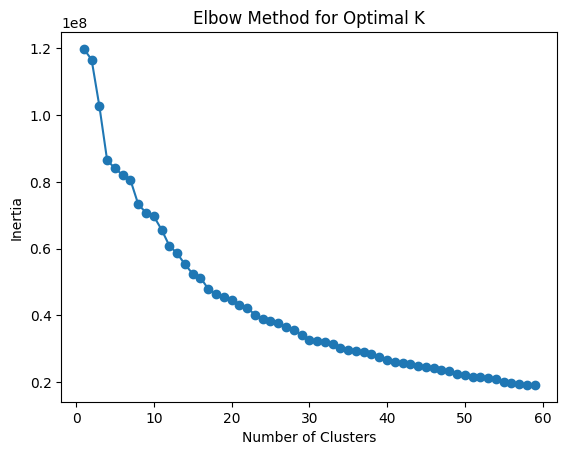

In [7]:
inertia = []
k_range = range(1, 60)  # Try 1 to 10 clusters, you can adjust the range as needed
for k in k_range:
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(artist_vectors)
    inertia.append(k_means.inertia_)
# Plot the Elbow Method graph
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')

We should choose cluster = 4 because it's the elbow point.

In [14]:
k_means = KMeans(n_clusters=30, max_iter=300, random_state=42)  
k_means.fit(artist_vectors)

KMeans(n_clusters=30, random_state=42)

In [15]:
labels = k_means.labels_ # each artist, assign the label of cluster to it. 

In [16]:
import random
def recommend_cluster(playlist_id):
    # Step 1: Extract the genres for the selected playlist
    my_all_genres = playlist_genres_dup.loc[playlist_id, 'genres']
    
    # Step 2: Count the genres and calculate the genre distribution as percentages
    my_genre_counts = Counter(my_all_genres)
    total_genres = len(my_all_genres)
    
    # Create the genre vector (percentage for each genre)
    my_vector = []
    for genre in common_genres:
        count = my_genre_counts.get(genre, 0)
        percentage = (count / total_genres) * 100
        my_vector.append(percentage)
    my_vector = np.array(my_vector)

    # Step 3: Using Cluster Analysis 
    my_vector = my_vector.reshape(1, -1)
    centroids = k_means.cluster_centers_
    distances = np.linalg.norm(centroids - my_vector, axis=1) #euclidean 
    closest_cluster_idx = np.argmin(distances)

    artists_in_cluster = [idx for idx, label in enumerate(labels) if label == closest_cluster_idx] #get artists in that cluster
    top_artists = [unique_artists_df['artist_name'][idx] for idx in artists_in_cluster]
    selected_artists = random.sample(top_artists, min(5, len(top_artists)))
    
    # Step 6: Get the existing tracks in the playlist to filter out from recommendations
    existing_tracks = tracks_df[tracks_df['playlist_pid'] == playlist_id]['track_uri'].values
    
    # Step 7: Recommend songs from the top artists, excluding already existing tracks
    recommended_songs = []
    for artist in selected_artists:
        if len(recommended_songs) >= 5: 
            break
        artist_songs = tracks_df[tracks_df['artist_name'] == artist]
        artist_songs = artist_songs[~artist_songs['track_uri'].isin(existing_tracks)] 
        
        if not artist_songs.empty:
            top_song = artist_songs.sample(n=1).iloc[0]  
            recommended_songs.append({
                'track_name': top_song['track_name'],
                'artist_name': top_song['artist_name'],
                'album_name': top_song['album_name'],
            })
    
    recommended_songs_df = pd.DataFrame(recommended_songs)
    
    return recommended_songs_df


In [17]:
playlist_id = int(input("Enter Playlist ID: "))  # Take user input for playlist ID
recommended_songs_df = recommend_cluster(playlist_id)
recommended_songs_df

Enter Playlist ID:  110


,track_name,artist_name,album_name
0,Storm of creation,The Graviators,The Graviators
1,Nettle Bed - Remastered 2006,Soft Machine,Seven
2,Chapala,Ale,Chill-sur-mer
3,Future,Dux,Future
4,My Stance,Freedom,USA Hardcore


## Step 7: One-hot Encoding Approach

* Loop through my unique playlist_genres
* Check if each of my genres contain in the list called common_genres
* If it contained --> put 1 at that index. And 0, otherwise.

In [58]:
cosine_sim = cosine_similarity(one_hot_vector.reshape(1, -1), artists_genre_matrix)
top_5_cossim = np.argsort(cosine_sim[0])[::-1][:5]
top_5_artists = unique_artists_df.iloc[top_5_cossim]['artist_uri'].values
existing_tracks = myplaylist_genres['track_uri']
recommended_songs = []
for artist_uri in top_5_artists:
    artist_songs = tracks_df[tracks_df['artist_uri'] == artist_uri]
    artist_songs = artist_songs[~artist_songs['track_uri'].isin(existing_tracks)]
    if not artist_songs.empty:
        top_song = artist_songs.iloc[0]
        recommended_songs.append({
                'track_name': top_song['track_name'],
                'artist_name': top_song['artist_name'],
                'album_name': top_song['album_name']
            })
recommendations_df = pd.DataFrame(recommended_songs)
print(recommendations_df.to_string(index=False))

            track_name      artist_name                                album_name
This Must Be The Place      Iron & Wine                        Sing Into My Mouth
        Left Of Center     Suzanne Vega The Best Of Suzanne Vega - Tried And True
         Call Me Maybe Carly Rae Jepsen                                      Kiss
                Jolene   Ray LaMontagne                                   Trouble
      The Sweet Escape     Gwen Stefani                          The Sweet Escape


In [15]:
def cb_recommend1(playlist_pid):
    all_genres = playlist_genres_dup.loc[playlist_id, 'genres']
#Step 1: Convert genres into one-hot encoding with common_genres
    one_hot_vector = np.zeros(len(common_genres))
    for genre in all_genres:
        if genre in common_genres:
            index = common_genres.index(genre)
            one_hot_vector[index]=1
#Step 2: Compute CS of one-hot vector and artist_genres_matrix
    cosine_sim = cosine_similarity(one_hot_vector.reshape(1, -1), artists_genre_matrix)
    top_5_cossim = np.argsort(cosine_sim[0])[::-1][:5]
    top_5_artists = unique_artists_df.iloc[top_5_cossim]['artist_uri'].values
    existing_tracks = tracks_df[tracks_df['playlist_pid'] == playlist_id]['track_uri'].values
#Step 3: Recommend songs
    recommended_songs = []
    for artist_uri in top_5_artists:
        artist_songs = tracks_df[tracks_df['artist_uri'] == artist_uri]
        artist_songs = artist_songs[~artist_songs['track_uri'].isin(existing_tracks)]
        if not artist_songs.empty:
            top_song = artist_songs.sample(n=1).iloc[0]  #recommend random song from that artist
            recommended_songs.append({
                'track_name': top_song['track_name'],
                'artist_name': top_song['artist_name'],
                'album_name': top_song['album_name']
            })
    recommendations_df = pd.DataFrame(recommended_songs)
    return recommendations_df

In [16]:
playlist_id = int(input("Enter Playlist ID: "))  # Take user input for playlist ID
recommended_songs_df = cb_recommend1(playlist_id)
recommended_songs_df

Enter Playlist ID:  110


,track_name,artist_name,album_name
0,Going Red,KANGA,KANGA
1,Holding On,Netta,Tropic New Wave
2,This Is The World We Live In,Alcazar,Dancefloor Deluxe
3,Madhouse,Anthrax,Spreading The Disease
4,Whore,In This Moment,Blood
